## Part 3: Build an RNN Model
Steps:
1. Load data and pre-trained embeddings;
2. Model Architecture;
3. compile the model;
4. Train model using???
5. Inference

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import HTML

InteractiveShell.ast_node_interactivity = 'all'  # display full outputs in Jupyter
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [3]:
import os
import numpy as np
import pandas as pd

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3616703606219534289
]


### Load the data

In [5]:
from utils import format_sequence, make_sequences, create_train_valid

Using TensorFlow backend.


In [6]:
patent_data = pd.read_csv('../data/neural_network_patent_query.csv', parse_dates=['patent_date'])

In [7]:
original_abstracts = list(patent_data['patent_abstract'])
abstracts = [format_sequence(i) for i in original_abstracts]

In [8]:
# generate sequences
word_idx, idx_word, num_words, word_counts, new_texts, new_sequences, features, labels = make_sequences(abstracts)

There are 11695 unique words.
There are 293001 sequences.


In [9]:
X_train, X_valid, y_train, y_valid = create_train_valid(features, labels, num_words)

In [24]:
# create a dict for training / validation set
training_dict = {'X_train': X_train, 'X_valid': X_valid, 'y_train': y_train, 'y_valid': y_valid}

### Build the model

With data encoded as integers and an embedding matrix of pre-trained word vectors, we're ready to build the recurrent neural network. This model is relatively simple and uses an LSTM cell as the heart of the network. After converting the words into embeddings, we pass them through a single LSTM layer, then into a fully connected layer with relu activation before the final output layer with a softmax activation. The final layer produces a probability for every word in the vocab.

When training, these predictions are compared to the actual label using the categorical_crossentropy to calculate a loss. The parameters (weights) in the network are then updated using the Adam optimizer (a variant on Stochastic Gradient Descent) with gradients calculated through backpropagation. Fortunately, Keras handles all of this behind the scenes, so we just have to set up the network and then start the training. The most difficult part is figuring out the correct shapes for the inputs and outputs into the model.

### Make RNN 
- Embedding dimension = 100
- 64 LSTM cells in one layer
- Dropout and recurrent dropout for regularization
- Fully connected layer with 64 units on top of LSTM
- 'relu' activation
- Drop out for regularization
- Output layer produces prediction for each word
- 'softmax' activation
- Adam optimizer with defaults
- Categorical cross entropy loss
- Monitor accuracy

In [10]:
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam

from keras.utils import plot_model

A dummy RMM model

In [26]:
X_train.shape
X_valid.shape
y_train.shape
y_valid.shape

(205100, 50)

(87901, 50)

(205100, 11695)

(87901, 11695)

In [24]:
# unique words
len(idx_word) + 1

11695

In [23]:
len(word_idx)

11694

## Model 1: Dummy LSTM: training our own embeddings

In [49]:
model = Sequential()

In [50]:
# Embedding layer: https://keras.io/layers/embeddings/
# This layer can only be used as the first layer in a model. Turns indexes into dense vectors of fixed size. 
# Input_dim: size of the vocabulary; Output_dim: dimension of the dense embedding
# In this case, we generate 100 dimension embeddings without using pre-trained embeddings. 
model.add(
    Embedding(
        input_dim=len(word_idx) + 1,
        output_dim=100
#         embeddings_initializer  # set to the pretrained word vectors
#         trainable=False
    )
)


In [51]:
# Recurrent LSTM layer
model.add(
    LSTM(
        64,
        return_sequences=False,
        dropout=0.1,
        recurrent_dropout=0.1
    )
)

In [52]:
# Fully Connected layer
model.add(
    Dense(64, input_shape=(64,), activation='relu')
)

In [53]:
# Dropout for regularization
model.add(Dropout(0.5))

In [54]:
# Output layer
# output layer predict a probability for each word
model.add(
    Dense(len(word_idx) + 1, input_shape=(64,), activation='softmax')
)

In [55]:
# Compile the model
# Optimizer: Adam 
# Loss function: categorical crossentropy
# metrics: accuracy
model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 100)         1169500   
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 11695)             760175    
Total params: 1,976,075
Trainable params: 1,976,075
Non-trainable params: 0
_________________________________________________________________


The model needs a loss to minimize (categorical_crossentropy) as well as a method for updating the weights using the gradients (Adam). We will also monitor accuracy which is not a good loss but can give us a more interpretable measure of the model performance.

Using pre-trained embeddings means we have about half the parameters to train. However, this also means that the embeddings might not be the best for our data, and there are a number of words with no embeddings

Built dummy-rnn Model.


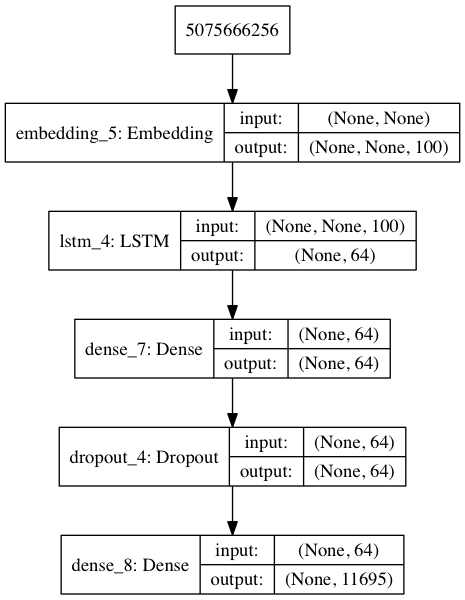

In [61]:
from IPython.display import Image
model_name = 'dummy-rnn'
model_dir = '../models/'

plot_model(model, to_file=f'{model_dir}{model_name}.png', show_shapes=True)

print(f'Built {model_name} Model.')
Image(f'{model_dir}{model_name}.png')

In [111]:
# Call backs
from keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5),
    ModelCheckpoint(f'{model_dir}{model_name}.h5', save_best_only=True,
                   save_weights_only=False)
]

In [57]:
# Fit model
model.fit(
    training_dict['X_train'], 
    training_dict['y_train'], 
    epochs=5, 
    batch_size=2048,
    validation_data = (training_dict['X_valid'], training_dict['y_valid']),
    verbose=1
)

Train on 205100 samples, validate on 87901 samples
Epoch 1/5
205100/205100 [==============================] - 223s 1ms/step - loss: 7.2639 - acc: 0.0654 - val_loss: 6.3358 - val_acc: 0.0931
Epoch 2/5
205100/205100 [==============================] - 221s 1ms/step - loss: 6.3322 - acc: 0.0919 - val_loss: 6.2479 - val_acc: 0.0931
Epoch 3/5
205100/205100 [==============================] - 218s 1ms/step - loss: 6.2626 - acc: 0.0919 - val_loss: 6.2404 - val_acc: 0.0931
Epoch 4/5
205100/205100 [==============================] - 214s 1ms/step - loss: 6.2393 - acc: 0.0919 - val_loss: 6.2328 - val_acc: 0.0931
Epoch 5/5
205100/205100 [==============================] - 217s 1ms/step - loss: 6.2107 - acc: 0.0924 - val_loss: 6.1960 - val_acc: 0.0931


## Evaluate the model and save model

In [59]:
scores = model.evaluate(
    X_valid, 
    y_valid, 
    batch_size=2048
)

87901/87901 [==============================] - 24s 274us/step


In [60]:
print(f'Cross Entropy: {round(scores[0], 4)} ')
print(f'Accuracy: {100*round(scores[1], 4)}% ')

Cross Entropy: 6.196 
Accuracy: 9.31% 


save the Keras model into a single HDF5 file which will contain:
- the architecture of the model, allowing to re-create the model
- the weights of the model
- the training configuration (loss, optimizer)
- the state of the optimizer, allowing to resume training exactly where you left off.

In [64]:
# serialize model to HDF5
model.save(f'{model_dir}{model_name}.h5')

## Generating prediction

Here, by using the RNN model, we are able to get a maximum probability for each word, which is used to predict the next word, given inputs of a sequences. 
To generate an inference, we need to put in a sequence of integers first. Starting off with a seed sequence with a seed_length = 50. 

One important parameter for the output is the diversity of the predictions. Instead of using the predicted word with the highest probability, we inject diversity into the predictions and then choose the next word with a probability proportional to the more diverse predictions. Too high a diversity and the generated output starts to seem random, but too low and the network can get into recursive loops of output.

In [105]:
# Create a Tokenizer
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=None,
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                     lower=True,
                     split=' ' 
                     )

In [106]:
# Train the tokenizer to the texts
tokenizer.fit_on_texts(abstracts)

# Convert list of strings into list of integers
sequences = tokenizer.texts_to_sequences(abstracts)

In [67]:
import random

In [107]:
seq = random.choice(sequences)
len(seq)

131

In [72]:
# Choose a random starting point
seed_length = 50
seed_start_idx = random.randint(0, len(seq) - seed_length - 10)
seed_end_idx = seed_start_idx + seed_length

In [76]:
# Extract the seed sequence
seed_seq = seq[seed_start_idx:seed_end_idx]
original_seed_seq = [idx_word[i] for i in seed_seq]
len(original_seed_seq)

50

In [82]:
# actual sequences with new words 
new_words = 30
actual = seed_seq[:] + seq[seed_end_idx:seed_end_idx + new_words]

In [98]:
# generate one new word
# The input data, as a Numpy array (or list of Numpy arrays if the model has multiple inputs).
pred_output = model.predict(np.array(seed_seq).reshape(1, -1))[0].astype(np.float64)

In [99]:
# The diversity controls the amount of stochasticity in the predictions: the next word predicted is selected based on the probabilities of the predictions.
diversity = 0.75
exp_preds = np.exp(np.log(pred_output) / diversity)

# Softmax
preds = exp_preds / sum(exp_preds)

In [100]:
preds.shape

(11695,)

In [101]:
probas = np.random.multinomial(1, preds, 1)[0]
probas.shape

(11695,)

In [112]:
next_idx = np.argmax(probas)
idx_word.get(next_idx, None)

'a'

### Generate a sequence of new words and comparing to actual sequence

In [118]:
new_id = seed_seq
new_w_seq = original_seed_seq
    
for w in range(new_words):
    pred_output = model.predict(np.array(new_id).reshape(1, -1))[0].astype(np.float64)
    exp_preds = np.exp(np.log(pred_output) / diversity)
    preds = exp_preds / sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)[0]
    
    next_idx = np.argmax(probas)
    next_word = idx_word.get(next_idx, None)
    
    new_id += [next_idx]
    new_w_seq.append(next_word)   


### Prediction

In [120]:
from utils import seed_sequence

In [121]:
s = 'This patent provides a basis for using a recurrent neural network to '

In [122]:
s = 'This patent provides a basis for using a recurrent neural network to '
HTML(seed_sequence(model, s, word_idx, idx_word, diversity = 0.75, num_words = 20))